In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib




# Ephaptic Coupling #

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
from neuron import h

## Fetch model files
### Cell type and cell parameters ###

In [3]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5.hoc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : 0,  #how this work? let's put 0 and not a negative number
    'tstop' : 30,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
}

### Creating generator_cell

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)

### Puting Synapse ###

In [5]:
synapse = LFPy.Synapse(generator_cell, 
                       idx = generator_cell.get_idx("soma[0]"),
                       syntype = 'Exp2Syn', 
                       weight = 0.005, 
                       e = 15, 
                       tau1 = 0.5,
                       tau2 = 2,
                       record_current = True)
synapse.set_spike_times(np.array([2.,15]))

### Measuring the external field in the positions of receptor_cell

In [6]:
# place electrodes at each segment of the cell
# define parameters for extracellular recording electrode, using optional method
# x,y,z are coordinates of contacts (from the grid in xz-plane over which we calculate local field potentials)
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    'x' : generator_cell.xmid,      # + distance of the electrodes to the receptor cell
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# perform NEURON simulation of the generator cell
# results saved as attributes in the cell instance
generator_cell.simulate(electrode = electrode,rec_vmem=True)

Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-

### Creating Receptor_cell

In [7]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.Cell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100

# time of extracellular field simulation
t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt

# insert external field generated by the generator cell recorded in electrodes
receptor_cell.insert_v_ext(electrode.LFP, t)

# perform NEURON simulation of the receptor cell
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


### Find Index positions of electrodes in the receptor cell

In [8]:
positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))

target = np.array([1000,100])      # estimated location in the plot
target_index = ((positions - target)**2).sum(axis=1).argmin()     # find closest electrode

target_pos = positions[target_index]       # find target electrode index
print('Target index is:', target_index)
print('Target position is:',target_pos)

Target index is: 124
Target position is: [989.4666748  114.66019058]


### Index positions of electrodes in the receptor cell that will be plotted

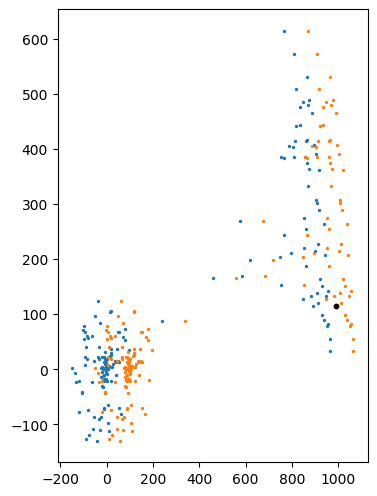

In [9]:
plt.figure(dpi=100,
          figsize=(4,6))

plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2) #blue
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2) #orange

plt.scatter(target_pos[0],target_pos[1],s=10,color='k')

### Plot of ephaptic coupling between the cells in SOMA

([<matplotlib.lines.Line2D at 0x7f44bc9bec10>],
 Text(0.5, 1.0, 'Receptor somatic voltage (mV)'))

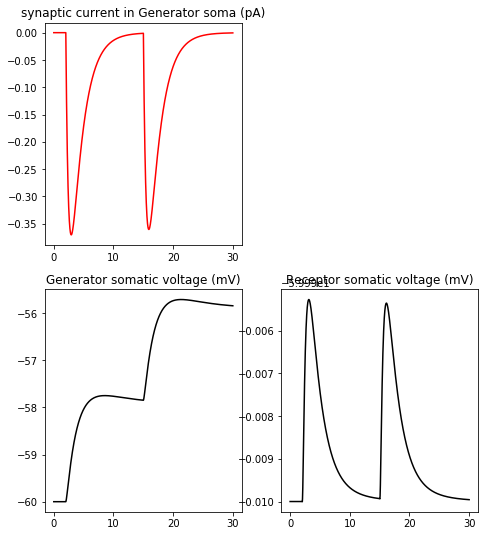

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(232)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('synaptic current in Generator soma (pA)')

plt.subplot(235)
plt.plot(generator_cell.tvec, generator_cell.somav, 'k'), plt.title('Generator somatic voltage (mV)')

plt.subplot(236)
plt.plot(receptor_cell.tvec, receptor_cell.somav, 'k'), plt.title('Receptor somatic voltage (mV)')

### Plot of ephaptic coupling between the cells: Vmem of the indexed position 

([<matplotlib.lines.Line2D at 0x7f44bc8b3e90>],
 Text(0.5, 1.0, 'Receptor: membrane voltage in index position(mV)'))

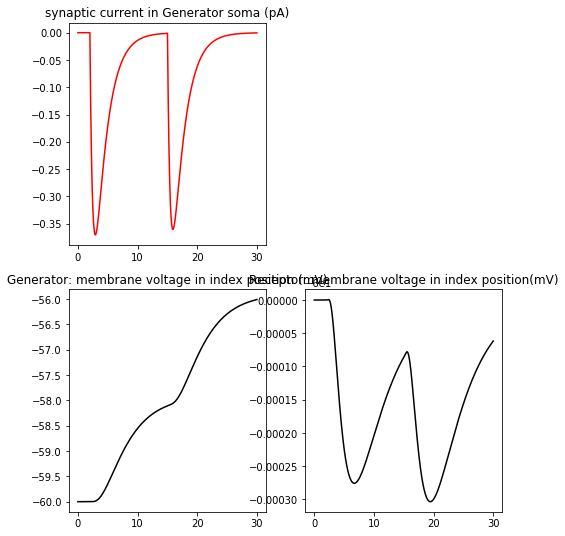

In [11]:
plt.figure(figsize=(12, 9))
plt.subplot(232)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('synaptic current in Generator soma (pA)')

plt.subplot(235)
plt.plot(generator_cell.tvec, generator_cell.vmem[target_index], 'k'), plt.title('Generator: membrane voltage in index position (mV)')

plt.subplot(236)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[target_index], 'k'), plt.title('Receptor: membrane voltage in index position(mV)')
